In [1]:
import numpy as np 
import pandas as pd 
import glob 
import random 
import os 

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요
base_folder =  '/home/user/torch_ubuntu/src/data/ETRI_lifelog_dataset'
folder = '/ch2025_data_items'

data_dir = base_folder + folder 


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# --------------------------- # 
# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 


✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: wPedo, shape = (748100, 9)


In [2]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


### 모바일 기기 충전 상태 

In [3]:
def process_mACStatus(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df = df.sort_values(['subject_id', 'timestamp']) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_charging'].values # 0/1 상태 
        times = group['timestamp'].values # 충전 상태 비율 
        ratio_charging = status.mean() 
        # 상태 전이 횟수 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        lengths = [] 
        current_len = 0 
        for val in status: 
            if val == 1: 
                current_len += 1 
            elif current_len > 0: 
                lengths.append(current_len) 
                current_len = 0 
        if current_len > 0: 
            lengths.append(current_len) 
        avg_charging_duration = np.mean(lengths) if lengths else 0 
        max_charging_duration = np.max(lengths) if lengths else 0 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'charging_ratio': ratio_charging, 
            'charging_transitions': transitions, 
            'avg_charging_duration': avg_charging_duration, 
            'max_charging_duration': max_charging_duration, 
        }) 
    return pd.DataFrame(results) 

mACStatus_df2 = process_mACStatus(mACStatus_df) 

mACStatus_df2.subject_id.unique()

array(['id01', 'id02', 'id03', 'id04', 'id05', 'id06', 'id07', 'id08',
       'id09', 'id10'], dtype=object)

In [4]:
mACStatus_df2[mACStatus_df2['subject_id'] == 'id01'].sort_values('date')

# 날짜 별 평균

,subject_id,date,charging_ratio,charging_transitions,avg_charging_duration,max_charging_duration
0,id01,2024-06-26,0.215859,22,13.363636,41
1,id01,2024-06-27,0.158571,32,13.875000,65
2,id01,2024-06-28,0.180282,29,17.066667,76
3,id01,2024-06-29,0.286567,3,192.000000,328
4,id01,2024-06-30,0.144286,8,50.500000,91
...,...,...,...,...,...,...
63,id01,2024-09-10,0.222066,9,63.200000,109
64,id01,2024-09-11,0.205038,17,32.555556,83
65,id01,2024-09-12,0.135294,10,36.800000,83
66,id01,2024-09-13,0.122464,8,42.250000,80


* 그래프

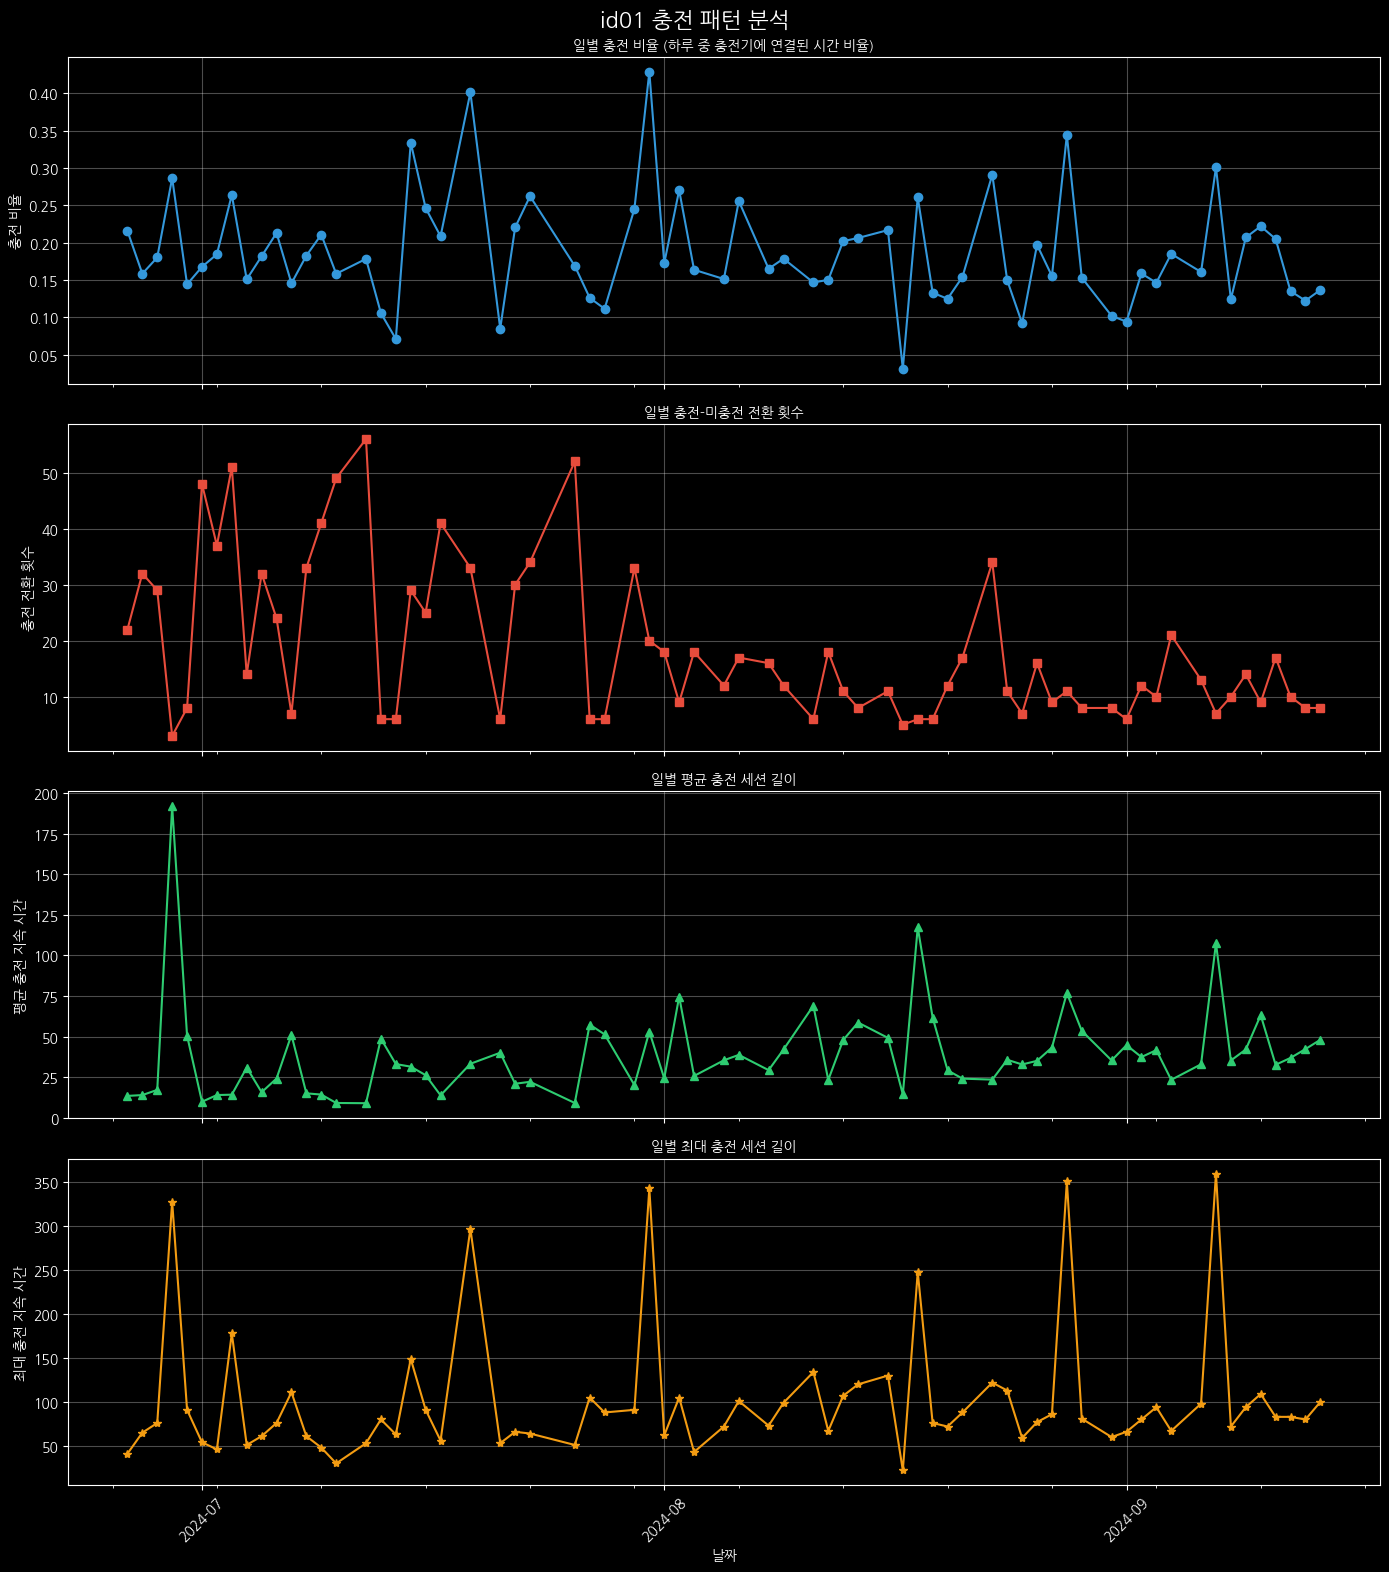

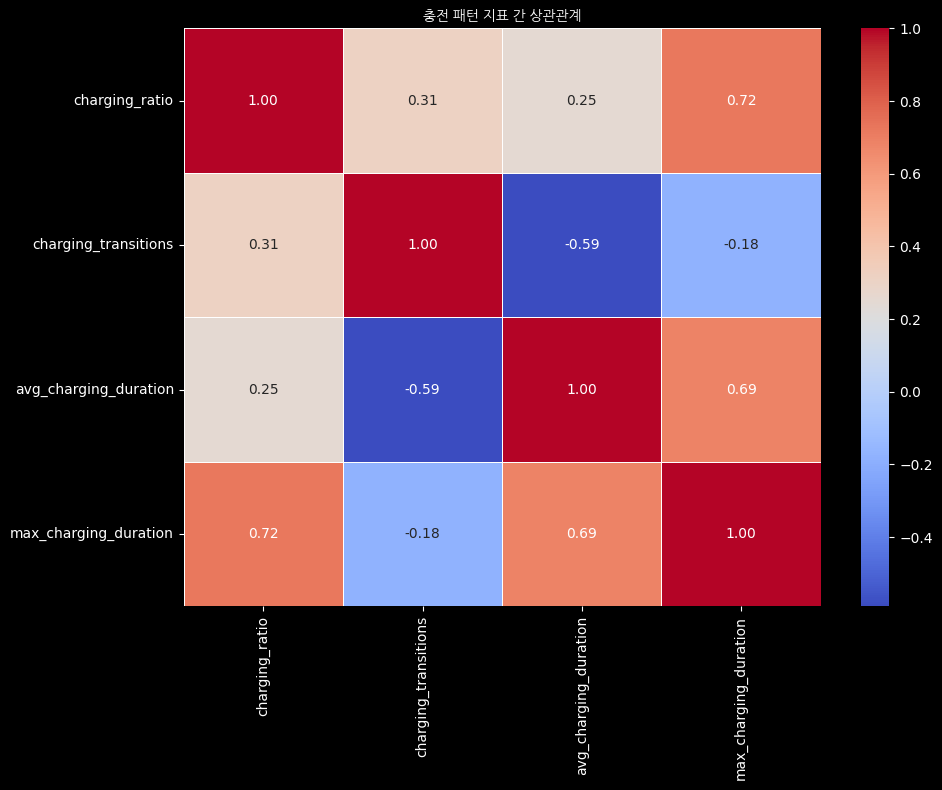

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# 데이터가 이미 정렬되어 있다고 가정하고, id01 데이터를 변수에 저장
id01_data = mACStatus_df2[mACStatus_df2['subject_id'] == 'id01'].sort_values('date')

# 시각화를 위해 date를 datetime 형식으로 변환 (이미 datetime이라면 이 단계는 건너뛰어도 됨)
id01_data['date'] = pd.to_datetime(id01_data['date'])

# 그래프 스타일 설정
plt.style.use('dark_background')
fig, axs = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
fig.suptitle('id01 충전 패턴 분석', fontsize=16, fontproperties=font_prop)  # 제목에 폰트 적용

# 1. 충전 비율 그래프
axs[0].plot(id01_data['date'], id01_data['charging_ratio'], marker='o', linestyle='-', color='#3498db')
axs[0].set_ylabel('충전 비율', fontproperties=font_prop)  # y축 레이블에 폰트 적용
axs[0].set_title('일별 충전 비율 (하루 중 충전기에 연결된 시간 비율)', fontproperties=font_prop)  # 제목에 폰트 적용
axs[0].grid(True, alpha=0.3)

# 2. 충전 전환 횟수 그래프
axs[1].plot(id01_data['date'], id01_data['charging_transitions'], marker='s', linestyle='-', color='#e74c3c')
axs[1].set_ylabel('충전 전환 횟수', fontproperties=font_prop)  # y축 레이블에 폰트 적용
axs[1].set_title('일별 충전-미충전 전환 횟수', fontproperties=font_prop)  # 제목에 폰트 적용
axs[1].grid(True, alpha=0.3)

# 3. 평균 충전 지속 시간 그래프
axs[2].plot(id01_data['date'], id01_data['avg_charging_duration'], marker='^', linestyle='-', color='#2ecc71')
axs[2].set_ylabel('평균 충전 지속 시간', fontproperties=font_prop)  # y축 레이블에 폰트 적용
axs[2].set_title('일별 평균 충전 세션 길이', fontproperties=font_prop)  # 제목에 폰트 적용
axs[2].grid(True, alpha=0.3)

# 4. 최대 충전 지속 시간 그래프
axs[3].plot(id01_data['date'], id01_data['max_charging_duration'], marker='*', linestyle='-', color='#f39c12')
axs[3].set_ylabel('최대 충전 지속 시간', fontproperties=font_prop)  # y축 레이블에 폰트 적용
axs[3].set_title('일별 최대 충전 세션 길이', fontproperties=font_prop)  # 제목에 폰트 적용
axs[3].grid(True, alpha=0.3)

# x축 날짜 포맷 설정
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    for label in ax.get_xticklabels():  # x축 눈금 레이블에 폰트 적용
        label.set_fontproperties(font_prop)
    for label in ax.get_yticklabels():  # y축 눈금 레이블에 폰트 적용
        label.set_fontproperties(font_prop)

plt.xlabel('날짜', fontproperties=font_prop)  # x축 레이블에 폰트 적용
plt.xticks(rotation=45, fontproperties=font_prop)  # x축 눈금 레이블에 폰트 적용
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# 상관관계 분석을 위한 히트맵 추가
plt.figure(figsize=(10, 8))
correlation_columns = ['charging_ratio', 'charging_transitions', 'avg_charging_duration', 'max_charging_duration']
corr = id01_data[correlation_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('충전 패턴 지표 간 상관관계', fontproperties=font_prop)  # 히트맵 제목에 폰트 적용
plt.tight_layout()
plt.show()